In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import matplotlib as plt
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


In [2]:
# pip install tensorflow

In [3]:
count = 0 
dirs = os.listdir('./Packets')
for dir in dirs:
    files = list(os.listdir('./Packets/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' Images')
    count = count + len(files)
print( 'Images Folder has '+ str(count) + ' Images')

Paper Folder has 9 Images
Plastic Folder has 9 Images
Images Folder has 18 Images


In [4]:
base_dir = './Packets'
val_dir = './Sample/'
img_size = 180
batch = 32

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 18 files belonging to 2 classes.
Using 15 files for training.
Found 18 files belonging to 2 classes.
Using 3 files for validation.


In [6]:
package_names = train_ds.class_names
package_names

['Paper', 'Plastic']

In [7]:
import matplotlib.pyplot as plt

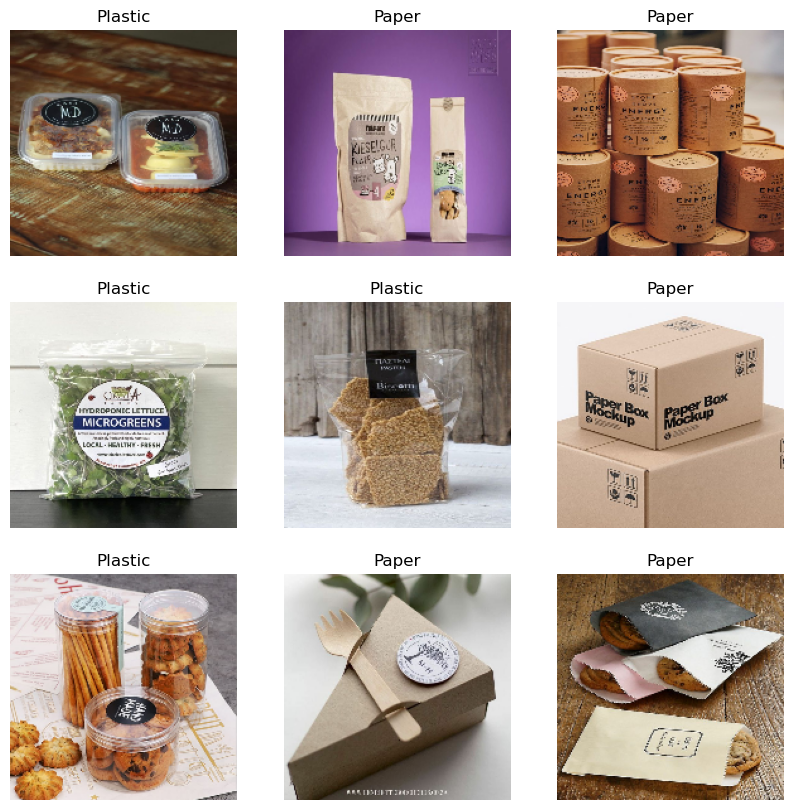

In [8]:
# Ensure class names are correctly defined
class_names = train_ds.class_names  

plt.figure(figsize=(10, 10))

# Take one batch from dataset
for images, labels in train_ds.take(1):
    num_images = images.shape[0]  # Get the actual number of images in the batch
    
    # Ensure we do not access out-of-bounds indices
    for i in range(min(num_images, 9)):  # Guarantees we don't exceed available images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(labels[i].numpy())])  # Convert label to integer
        plt.axis('off')

# Show the 9 images
plt.show()

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [11]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [12]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


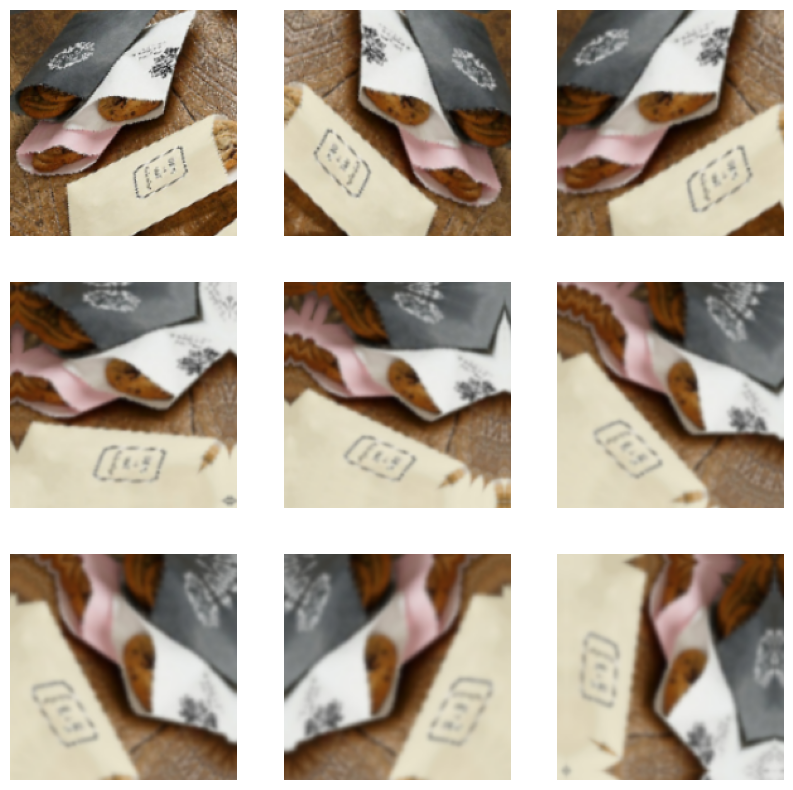

In [13]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [14]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 1.6187 - val_accuracy: 0.6667 - val_loss: 0.8005
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4667 - loss: 1.0553 - val_accuracy: 0.3333 - val_loss: 3.1104
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5333 - loss: 1.8979 - val_accuracy: 0.3333 - val_loss: 1.8539
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5333 - loss: 1.1995 - val_accuracy: 0.3333 - val_loss: 0.7835
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5333 - loss: 0.6713 - val_accuracy: 0.6667 - val_loss: 0.7450
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4667 - loss: 0.8364 - val_accuracy: 0.6667 - val_loss: 0.7560
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4667 - loss: 0.8537 - val_accuracy: 0.6667 - val_loss: 0.7320
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4667 - loss: 0.8090 - val_accuracy: 0.6667 - val_loss: 0.7136
Ep

In [18]:
model.save('package_classification.keras')
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + package_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

tf.keras.models.load_model('package_classification.keras')

<Sequential name=sequential_1, built=True>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(-0.5, 735.5, 979.5, -0.5)

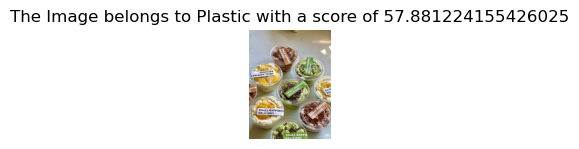

In [29]:
imgPath = './try/3.png'
prediction = classify_images(imgPath)
import matplotlib.image as mpimg
plt.subplot(3,3,3)
plt.imshow(mpimg.imread(imgPath))
plt.title(prediction)
plt.axis('off')